<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

***Some parts of the notebook are almost the exact copy of***  https://github.com/yandexdataschool/nlp_course

##  Attention

Attention layer can take in the previous hidden state of the decoder $s_{t-1}$, and all of the stacked forward and backward hidden states $H$ from the encoder. The layer will output an attention vector $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far $s_{t-1}$, and all of what we have encoded $H$, to produce a vector $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode $\hat{y}_{t+1}$. The decoder input word that has been embedded  $y_t$.

You can use any type of the attention scores between previous hidden state of the encoder $s_{t-1}$ and hidden state of the decoder $h \in H$, you prefer. We have met at least three of them:<br><br>

$$\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=\left\{\begin{array}{ll}
\boldsymbol{h}^{\top} \boldsymbol{s}_{t-1} & \text { dot } \\
\boldsymbol{h}^{\top} \boldsymbol{W}_{\boldsymbol{a}} \boldsymbol{s}_{t-1} & \text { general } \\
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) & \text { concat }
\end{array}\right.$$
--------


**_We wil use "concat attention"_**:

First, we calculate the *energy* between the previous decoder hidden state $s_{t-1}$ and the encoder hidden states $H$. As our encoder hidden states $H$ are a sequence of $T$ tensors, and our previous decoder hidden state $s_{t-1}$ is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. $\Rightarrow$<br>
We have:<br>
$$H = \bigl[\boldsymbol{h}_{0}, ..., \boldsymbol{h}_{T-1}\bigr] \\ \bigl[\boldsymbol{s}_{t-1}, ..., \boldsymbol{s}_{t-1}\bigr]$$

The encoder hidden dim and the decoder hidden dim should be equal: **dec hid dim = enc hid dim**.<br>
 We then calculate the energy, $E_t$, between them by concatenating them together:<br>

$$\bigl[[\boldsymbol{h}_{0}, \boldsymbol{s}_{t-1}], ..., [\boldsymbol{h}_{T-1}, \boldsymbol{s}_{t-1}]\bigr]$$

And passing them through a linear layer (`attn` = $\boldsymbol{W}_{\boldsymbol{a}}$) and a $\tanh$ activation function:

$$E_t = \tanh(\text{attn}(H, s_{t-1}))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[enc hid dim, src sent len]** tensor for each example in the batch. We want this to be **[src sent len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, enc hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$


We can think of this as calculating a weighted sum of the "match" over all `enc_hid_dem` elements for each encoder hidden state, where the weights are learned (as we learn the parameters of $v$).

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

### Temperature SoftMax

<img src="https://miro.medium.com/max/793/1*S5X1pBq_jfDreJOs7yP-ZQ.png" height=100>

This gives us the attention over the source sentence!

Graphically, this looks something like below. $z = s_{t-1}$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.


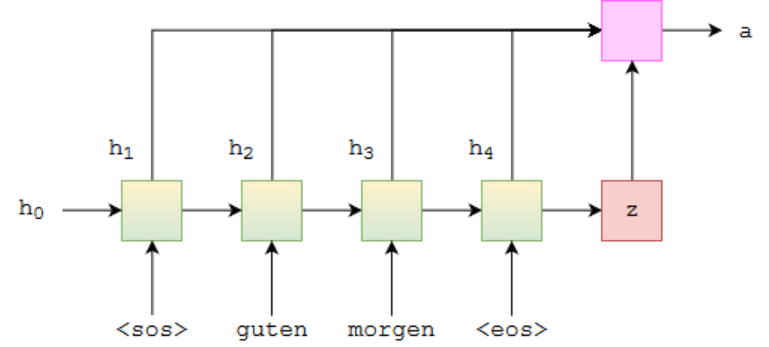

# Neural Machine Translation

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
! wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

--2022-11-23 11:44:33--  https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving drive.google.com (drive.google.com)... 64.233.183.113, 64.233.183.139, 64.233.183.101, ...
Connecting to drive.google.com (drive.google.com)|64.233.183.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hrh47l99sq4meohs3glqclqsasvlb5n5/1669203825000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_?uuid=725ddc6e-89e9-4d7d-978a-66b5a7a5f110 [following]
--2022-11-23 11:44:34--  https://doc-14-00-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hrh47l99sq4meohs3glqclqsasvlb5n5/1669203825000/16549096980415837553/*/1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_?uuid=725ddc6e-89e9-4d7d-978a-66b5a7a5f110
Resolving doc-14-00-docs.googleusercontent.com (doc-14-00-docs.googleusercontent.com)... 172.217.212.132, 2607:f8b0:4001:c03::84
Connecting to doc-1

In [2]:
!pip install -U torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.0 MB/s 
     |████████████████████████████████| 831.4 MB 2.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator

import spacy

import random
import math
import time
import numpy as np

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

We'll set the random seeds for deterministic results.

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Preparing Data

Here comes the preprocessing

In [5]:
tokenizer_W = WordPunctTokenizer()

def tokenize_ru(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())[::-1]

def tokenize_en(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize_ru,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


dataset = torchtext.legacy.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
print(len(dataset.examples))
print(dataset.examples[0].src)
print(dataset.examples[0].trg)

50000
['.', 'собора', 'троицкого', '-', 'свято', 'от', 'ходьбы', 'минутах', '3', 'в', ',', 'тбилиси', 'в', 'расположен', 'cordelia', 'отель']
['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']


In [8]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.05, 0.15])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 7500
Number of testing examples: 2500


In [9]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9256
Unique tokens in target (en) vocabulary: 6734


And here is example from train dataset:

In [11]:
print(vars(train_data.examples[9]))

{'trg': ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'grocery', 'deliveries', ',', 'laundry', 'and', 'ironing', 'services', '.'], 'src': ['.', 'услуги', 'гладильные', 'и', 'прачечной', 'услуги', ',', 'продуктов', 'доставка', 'предлагается', 'также']}


When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us! 

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

## Let's use modules.py

In [14]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [16]:
%cd ./drive/MyDrive/

/content/drive/MyDrive


## Encoder

For a multi-layer RNN, the input sentence, $X$, goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(x_t, h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Extending our multi-layer equations to LSTMs, we get:

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(x_t, (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$

<br><br>
<img src="https://drive.google.com/uc?id=1uIUxtZU8NvGdz0J9BlRSTbsBLFh32rxx">

In [17]:
# you can paste code of encoder from modules.py
# the encoder can be like seminar encoder but you have to return outputs
# and if you use bidirectional you won't make the same operation like with hidden
# because outputs = [src sent len, batch size, hid dim * n directions]

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, bidirectional):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, bidirectional=bidirectional)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        # Compute an embedding from the src data and apply dropout to it
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        outputs, (hidden, cell) = self.rnn(embedded)
  
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        if self.bidirectional:
          hidden = hidden.reshape(self.n_layers, 2, -1, self.hid_dim)
          hidden = hidden.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)

          cell = cell.reshape(self.n_layers, 2, -1, self.hid_dim)
          cell = cell.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)

        if self.n_layers > 1:
          hidden = hidden[-1:, :, :] # if n_layers > 1 take outputs from last hidden layer

        return outputs, hidden, cell


## Attention

$$\operatorname{score}\left(\boldsymbol{h}, \boldsymbol{s}_{t-1}\right)=
\boldsymbol{v}_{a}^{\top} \tanh \left(\boldsymbol{W}_{\boldsymbol{a}}\left[\boldsymbol{h} ; \boldsymbol{s}_{t-1}\right]\right) \text { - concat attention}$$

In [19]:
def softmax(x, temperature=1): # use your temperature
    e_x = torch.exp(x / temperature)
    return e_x / torch.sum(e_x, dim=0)

In [20]:
# you can paste code of attention from modules.py

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear(enc_hid_dim + dec_hid_dim, enc_hid_dim)
        self.v = nn.Linear(enc_hid_dim, 1)
        
    def forward(self, hidden, encoder_outputs):
        
        # hidden = [1, batch size, dec_hid_dim]
        # encoder_outputs = [src sent len, batch size, enc_hid_dim]

        src_len = encoder_outputs.shape[0]
        # repeat hidden and concatenate it with encoder_outputs
        hidden = hidden.permute(1,0,2)
        hidden = hidden.repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim]

        # calculate energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2).permute(1, 0, 2)))
        #energy = [batch size, src len, dec hid dim]


        # get attention, use softmax function which is defined, can change temperature
        attention = self.v(energy).squeeze(2) # [batch size, src len, 1] ==> [batch size, src len]
        #attention= [src len, batch size]
            
        return softmax(attention)

## Decoder with Attention

To make it really work you should also change the`Decoder` class from the classwork in order to make it to use `Attention`. 
You may just copy-paste `Decoder` class and add several lines of code to it.

The decoder contains the attention layer `attention`, which takes the previous hidden state $s_{t-1}$, all of the encoder hidden states $H$, and returns the attention vector $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The input word that has been embedded $y_t$, the weighted source vector $w_t$, and the previous decoder hidden state $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the **first** word in an example translation.

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block is $z = s_{t-1} = s_0$, the blue block shows the decoder RNN which outputs $s_t = s_1$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

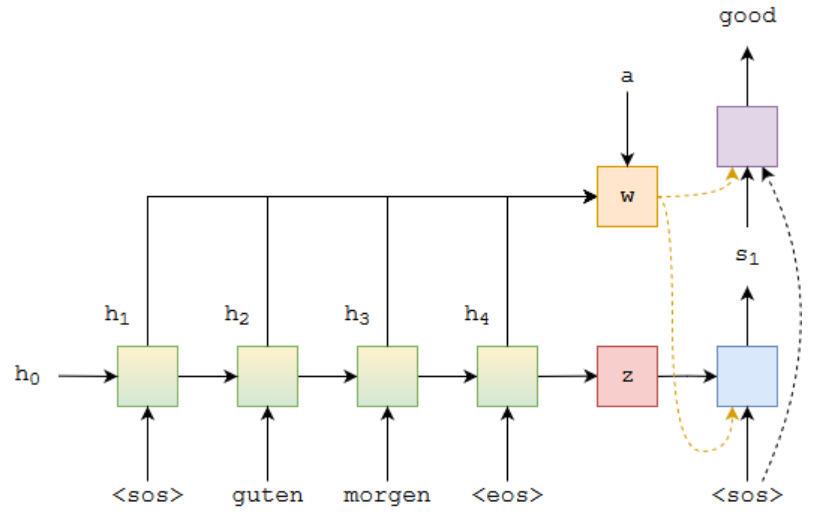

### Teacher forcing

Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input.

<img src="https://miro.medium.com/max/421/1*U3d8D_GnfW13Y3nDgvwJSw.png">

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference (i.e. real world usage) it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.



In [21]:
# you can paste code of decoder from modules.py

class DecoderWithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(enc_hid_dim + emb_dim, dec_hid_dim) # use GRU
        
        self.out = nn.Linear(enc_hid_dim + dec_hid_dim + emb_dim, output_dim) # linear layer to get next word
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):

        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0) # because only one word, no words sequence 
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]

        a = self.attention(hidden, encoder_outputs).permute(1,0)
        #a = [batch size, src len]
        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, enc hid dim]

        #get weighted sum of encoder_outputs
        weighted = torch.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, enc hid dim]
        weighted = weighted.permute(1, 0, 2)

        # concatenate weighted sum and embedded, break through the GRU
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, enc hid dim + emb dim]

        # get predictions
        hidden = hidden.squeeze(0)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #print('output.shape = ', output.shape)
        #output = [seq len, batch size, dec hid dim * n directions]
    
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all() # .all() returns True if all items in an iterable are true
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)        
        
        prediction = self.out(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]

        return prediction, hidden  


## Seq2Seq

Main idea:
* $w_t = a_t H$

* $s_t = \text{DecoderGRU}([y_t, w_t], s_{t-1})$

* $\hat{y}_{t+1} = f(y_t, w_t, s_t)$

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

In [22]:
# you can paste code of seq2seq from modules.py

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        if encoder.bidirectional:
            assert encoder.hid_dim * 2 == decoder.dec_hid_dim, \
                "Hidden dimensions of encoder and decoder must be equal!"
        else:
            assert encoder.hid_dim == decoder.dec_hid_dim, \
                "Hidden dimensions of encoder and decoder must be equal!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.4):
        
        # src = [src sent len, batch size]
        # trg = [trg sent len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        enc_states, hidden, cell = self.encoder(src)
        
        #first input to the decoder is the  tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):

            output, hidden = self.decoder(input, hidden, enc_states)

            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(-1) 
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## Training

In [23]:
import modules
import imp 
imp.reload(modules)

Encoder = modules.Encoder 
Attention = modules.Attention 
Decoder = modules.DecoderWithAttention 
Seq2Seq = modules.Seq2Seq

In [24]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
HID_DIM = 800
N_LAYERS = 2 
ENC_DROPOUT = .5
DEC_DROPOUT = .5
BIDIRECTIONAL = True

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM // 2, N_LAYERS, ENC_DROPOUT, BIDIRECTIONAL)
attention = Attention(HID_DIM, HID_DIM)
dec = DecoderWithAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, DEC_DROPOUT, attention)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [25]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9256, 300)
    (rnn): LSTM(300, 400, num_layers=2, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderWithAttention(
    (attention): Attention(
      (attn): Linear(in_features=1600, out_features=800, bias=True)
      (v): Linear(in_features=800, out_features=1, bias=True)
    )
    (embedding): Embedding(6734, 300)
    (rnn): GRU(1100, 800)
    (out): Linear(in_features=1900, out_features=6734, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 29,537,535 trainable parameters


In [27]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, OUTPUT_DIM)
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, OUTPUT_DIM)
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

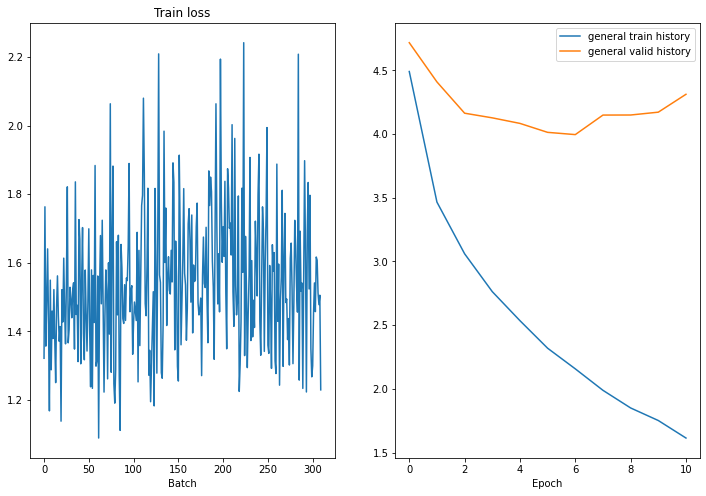

Epoch: 12 | Time: 6m 25s
	Train Loss: 1.542 | Train PPL:   4.675
	 Val. Loss: 4.373 |  Val. PPL:  79.270


In [29]:
train_history = []
valid_history = []

N_EPOCHS = 12
CLIP = 2

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [30]:
def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == '<eos>':
            break
        yield token

def remove_tech_tokens(tokens_iter, tokens_to_remove=['<sos>', '<unk>', '<pad>']):
    return [x for x in tokens_iter if x not in tokens_to_remove]

def generate_translation(src, trg, model, TRG_vocab):
    model.eval()

    output = model(src, trg, 0) #turn off teacher forcing
    output = output[1:].argmax(-1)

    original = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[x] for x in list(trg[:,0].cpu().numpy())]))
    generated = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[x] for x in list(output[:, 0].cpu().numpy())]))
    
    print('Original: {}'.format(' '.join(original)))
    print('Generated: {}'.format(' '.join(generated)))
    print()

def get_text(x, TRG_vocab):
     generated = remove_tech_tokens(cut_on_eos([TRG_vocab.itos[elem] for elem in list(x)]))
     return generated

In [31]:
#model.load_state_dict(torch.load('best-val-model.pt'))
batch = next(iter(test_iterator))

for idx in range(10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: there is a shared lounge at the property .
Generated: there is a shared lounge at the property .

Original: free wifi access is available .
Generated: free wifi is available .

Original: other facilities like grocery deliveries are offered .
Generated: grocery delivery service is available on request .

Original: you will find a shared lounge at the property .
Generated: there is a shared lounge at the property .

Original: free parking is provided .
Generated: free parking is available .

Original: each unit is fitted with a private bathroom with slippers .
Generated: slippers private bathroom can be found in the private bathroom .

Original: your meal with a glass of locally produced wine .
Generated: a wide range of a local wines is available .

Original: a tv is available .
Generated: a tv is available .

Original: a work desk is included .
Generated: extras include a work desk .

Original: at hilton garden inn reagan national airport you will find a 24 - hour front desk 

## Bleu

[link](https://www.aclweb.org/anthology/P02-1040.pdf)

<img src="https://drive.google.com/uc?id=1umJF2S8PiayxD9Xo8xvjW8QsrSLidozD" height=400>

In [32]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [33]:
import tqdm
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].argmax(-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output.detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

20it [00:04,  4.97it/s]


In [34]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

29.70722081747451

## Recommendations:
* use bidirectional RNN
* change learning rate from epoch to epoch
* when classifying the word don't forget about embedding and summa of encoders state 
* you can use more than one layer

## You will get:

* `2` points if `21 < bleu score < 23`
* `4` points if `23 < bleu score < 25`
* `7` points if `25 < bleu score < 27`
* `9` points if `27 < bleu score < 29`
* `10` points if `bleu score > 29`

When your result is checked, your 10 translations will be checked too


## Your Conclusion
* information about your the results obtained 
* difference between seminar and homework model

**ВЫВОД:** 
Удалось добиться bleu = 29.7. 

При построении словарей min_freq принималась равной 3.

При расчете softmax, temperature принималась равной 1. 

При обучении модели HID_DIM = 800.

Были использованы механизмы concat_Attention в классе Attention, и GRU в классе Decoder.